<a href="https://colab.research.google.com/github/varungole/digit-recognizer/blob/main/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [238]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [239]:
train = pd.read_csv('train.csv') # Loading training data
test = pd.read_csv('test.csv') # Loading test data
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [240]:
#Explolatory Data Analysis (EDA)

In [241]:
print(f"Training Dataset: \n\tnumber of images: {train.shape[0]}\n\tnumber of features: {train.shape[1]}")
print(f"\tmissing data: {train.isnull().sum().sum()}")

Training Dataset: 
	number of images: 42000
	number of features: 785
	missing data: 0


In [242]:
print(f"Test Dataset: \n\tnumber of images: {test.shape[0]}\n\tnumber of features: {test.shape[1]}")
print(f"\tmissing data: {test.isnull().sum().sum()}")

Test Dataset: 
	number of images: 28000
	number of features: 784
	missing data: 0


In [243]:
labels = train.label.value_counts().index # Get the class names
counts = train.label.value_counts() # Get the number of rows by class

print(f"Classes: {labels}")
print(f"Number of images per label: {counts}")

Classes: Int64Index([1, 7, 3, 9, 2, 6, 0, 4, 8, 5], dtype='int64')
Number of images per label: 1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


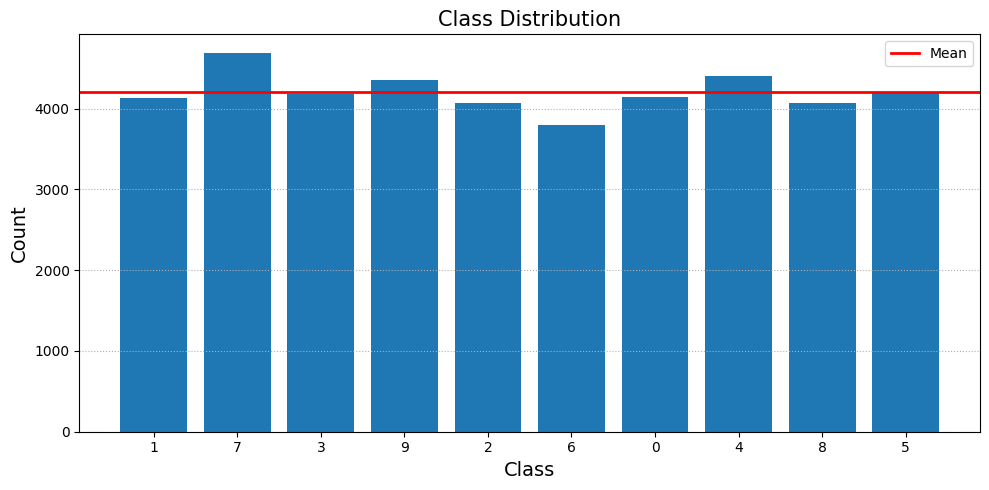

In [244]:
plt.figure(figsize=(10, 5))
plt.bar(labels, counts)
plt.xticks(np.arange(len(labels)), labels)
plt.xlabel('Class', fontsize=14) # Add text to the X-axis
plt.ylabel('Count', fontsize=14) # Add text to the Y axis
plt.title('Class Distribution', fontsize=15) # Add a header about class distribution

# We add a line to show the uniformity of the distribution of features
plt.axhline(counts.mean(), color='red', linewidth=2, label='Mean')

plt.legend()
plt.grid(axis='y', linestyle='dotted')

plt.tight_layout()
plt.show()

In [245]:
X = train.drop('label' , axis = 1)

In [246]:
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [247]:
print(f"Minimum pixel value for training dataset: {train.min().min()}")
print(f"Maximum pixel value for training dataset: {train.max().max()}")

Minimum pixel value for training dataset: 0
Maximum pixel value for training dataset: 255


In [248]:
X = np.array(X)

In [249]:
#now we set datatype to float
X = X.astype('float32')

In [250]:
#Normalize
X = X/ 255.0

In [251]:
#images are in graysscale, we convert them to RGB
X = cv2.cvtColor(X , cv2.COLOR_GRAY2RGB)

In [252]:
X = X.reshape(-1 , 28 , 28 , 3)

In [253]:
y = train.label

In [254]:
y

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64


Example of a training image for label :1


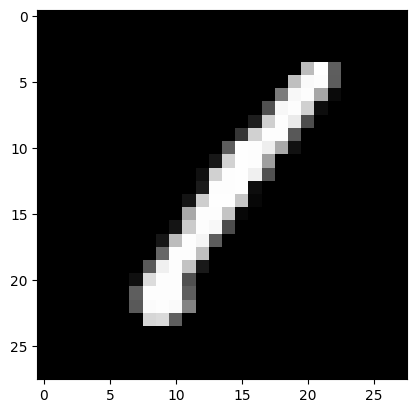

In [255]:
print(f"\nExample of a training image for label :{y[0]}")
train_img_plot = plt.imshow(X[0])
plt.show()

In [256]:
#we need to preprocess test dataset as well

Minimum pixel value for test dataset: 0
Maximum pixel value for test dataset: 255

Example of a test image


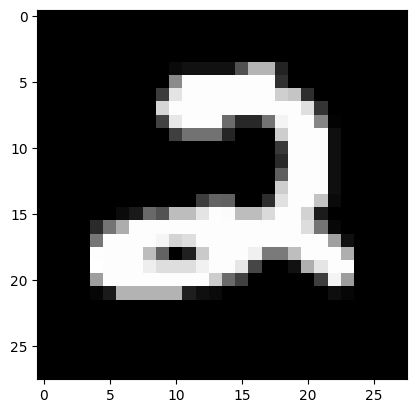

In [257]:
## Test dataset

test = np.array(test) # Convert DataFrame to numpy array

# Change the color depth from 0 to 1
print(f"Minimum pixel value for test dataset: {test.min().min()}")
print(f"Maximum pixel value for test dataset: {test.max().max()}")

test = test.astype('float32') # Set datatype as float32
test = test / 255.0 # Normalize pixel value

# Convert an image from grayscale to RGB
test = cv2.cvtColor(test, cv2.COLOR_GRAY2RGB)
test = test.reshape(-1, 28, 28, 3)


print(f"\nExample of a test image")
test_img_plot = plt.imshow(test[0])
plt.show()

In [258]:
#Now, we need to do data preprocessing for deep learning

In [259]:
X_train , X_val , y_train , y_val = train_test_split(X, y, test_size=0.20, random_state=16)

In [260]:
#Convert training and tresting datasets from numpy to torch datasets

In [261]:
X_train_t = torch.from_numpy(X_train).float()

In [262]:
y_train_t =  torch.from_numpy(y_train.values)

In [263]:
train_tensor = TensorDataset(X_train_t, y_train_t)



In [264]:
X_val_t =  torch.from_numpy(X_val).float()
y_val_t =  torch.from_numpy(y_val.values)
val_tensor = TensorDataset(X_val_t, y_val_t)

X_test_t = torch.from_numpy(test).float()


In [265]:
batch_size = 16

In [266]:
# Load image into data generator
train_loader = DataLoader(train_tensor, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(X_test_t, batch_size=batch_size, num_workers=2, shuffle=False)

loaders = {"train": train_loader, "valid": val_loader}

In [267]:
#Let’s check to see if torch.cuda or torch.backends.mps are available, otherwise we use the CPU.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [268]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
            )

    def forward(self, x):
        x = self.flatten(x)
        output = self.linear_relu_stack(x)
        return output


In [269]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2352, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [270]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [271]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [272]:
def train_loop(data_loader, model, loss_fn, optimizer):
    size = len(data_loader.dataset)

    # set the model to training mode
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        # compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch% 100 == 0:
            loss, current  = loss, (batch + 1)*len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [273]:
def test_loop(data_loader, model, loss_fn):
    # set the model to evaluation mode
    model.eval()

    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in data_loader:
            pred = model(X)
            test_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [274]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(val_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300272  [   16/33600]
loss: 2.292900  [ 1616/33600]
loss: 2.277960  [ 3216/33600]
loss: 2.296617  [ 4816/33600]
loss: 2.268888  [ 6416/33600]
loss: 2.237987  [ 8016/33600]
loss: 2.270669  [ 9616/33600]
loss: 2.219647  [11216/33600]
loss: 2.213568  [12816/33600]
loss: 2.226824  [14416/33600]
loss: 2.222985  [16016/33600]
loss: 2.185598  [17616/33600]
loss: 2.130462  [19216/33600]
loss: 2.165020  [20816/33600]
loss: 2.102722  [22416/33600]
loss: 2.128736  [24016/33600]
loss: 2.080613  [25616/33600]
loss: 2.078081  [27216/33600]
loss: 2.021899  [28816/33600]
loss: 2.042278  [30416/33600]
loss: 1.940068  [32016/33600]
Test Error: 
 Accuracy: 70.8%, Avg loss: 1.931697 

Epoch 2
-------------------------------
loss: 1.966576  [   16/33600]
loss: 1.848012  [ 1616/33600]
loss: 1.683769  [ 3216/33600]
loss: 1.750718  [ 4816/33600]
loss: 1.679037  [ 6416/33600]
loss: 1.566143  [ 8016/33600]
loss: 1.772833  [ 9616/33600]
loss: 1.491268  [11216/33600

In [275]:
# Prediction
logits = model(X_test_t)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([2, 0, 9,  ..., 3, 9, 2])



Test image prediction
Prediction: 7


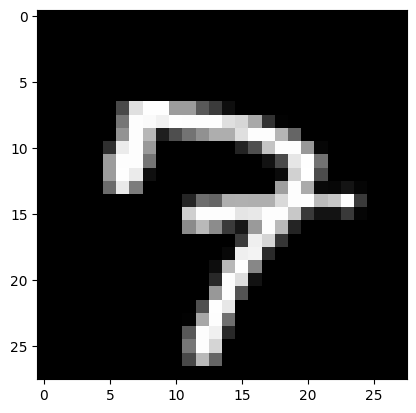

In [276]:
print(f"\nTest image prediction")
print(f"Prediction: {y_pred[5]}")
test_img_plot = plt.imshow(X_test_t[5])
plt.show()

In [277]:
results = pd.Series(y_pred,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("mnist_prediction.csv",index=False)
